In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
%matplotlib inline

In [40]:
def clean_raw(bc_full_df):
    import numpy as np
    import pandas as pd
    import pandas as pd
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    %matplotlib inline

    #alsways drop these cols
    #try:
    bc_full_df = bc_full_df.drop('Worksheet Filter',axis=1)
    bc_full_df = bc_full_df.drop('Measure Display',axis=1)
    bc_full_df = bc_full_df.drop('Number of Records',axis=1)
    bc_full_df = bc_full_df.drop('Unnamed: 0',axis=1)
    bc_full_df = bc_full_df.drop('State',axis=1)
    bc_full_df = bc_full_df.drop('Table Id',axis=1)
    bc_full_df = bc_full_df.drop('Period Duration',axis=1)
    bc_full_df = bc_full_df.drop('Period Begin',axis=1)
    #except:
    #    pass
    
    #drop when doing neighborhoods
#     bc_full_df = bc_full_df.drop('months_of_supply',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_yoy',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_mom',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Yoy',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Mom',axis=1)

    #lgo transforms of two variables so I can potentially use the additive decomposition
    bc_full_df['Inventory'] = np.log(bc_full_df['Inventory'])
    bc_full_df['months_of_supply'] = np.log(bc_full_df['months_of_supply'])


    #rename months_of_supply
    bc_full_df.rename(columns = {'months_of_supply': 'Months of Supply',
                                'months_of_supply_mom': 'Months of Supply Mom',
                                'months_of_supply_yoy': 'Months of Supply Yoy'}, inplace=True)

    #drop 2nd date col
    dates = ['Period End'] #dropped Period End
    for col in dates:
        bc_full_df[col] = pd.to_datetime(bc_full_df[col])
    
    #format percent cols
    percents = ['Median Sale Price Mom',
    'Median Sale Price Yoy',
    'New Listings Mom',
    'New Listings Yoy',
    'Homes Sold Mom',
    'Homes Sold Yoy',
    'Inventory Mom',
    'Inventory Yoy',
    'Avg Sale To List Mom',
    'Avg Sale To List Yoy']
    for col in percents:
        bc_full_df[col] = bc_full_df[col].str.strip('%')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
        
    #format money cols
    prices = ['Median Sale Price']
    for col in prices:
        bc_full_df[col] = bc_full_df[col].str.strip('$').str.strip('K').str.replace(',','')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
    
    #change scale
    bc_full_df['Median List Price'] = bc_full_df['Median List Price'] / 1000.0
    
    #set index
    bc_full_df = bc_full_df.sort_values('Period End')
    bc_full_df = bc_full_df.set_index('Period End')
    
    return bc_full_df

In [3]:
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [4]:
#test_stationarity(differenced(bos['Median Dom']).values.ravel())

In [5]:
def decomp(series,trend=False,seas=False,resid=True,model='add'):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    df = pd.DataFrame()
    col_decomp = sm.tsa.seasonal_decompose(series, model=model,two_sided=False)
    #df[col] = col_decomp.observed
    if trend:
        df[series.name+' Trend'] = col_decomp.trend
    if seas:
        df[series.name+' Seasonal'] = col_decomp.seasonal
    if resid:
        df[series.name+' Residual'] = col_decomp.resid
    return df#, target_trend, target_seasonal

In [6]:
def diff(series,lag1=True,lag12=True):
    df = pd.DataFrame()
    lag = (series-series.shift(1)).dropna(axis=0)
    if lag1 and lag12:
        df[series.name+' Lag'] = (lag - lag.shift(12)).dropna()
    elif lag1:
        df[series.name+' Lag1'] = lag
    elif lag12:
        df[series.name+' Lag12'] = (series - series.shift(12)).dropna()
    return df

In [46]:
def read_data(df,reg_type='metro'):
    #format data
    df = clean_raw(df)
    
    #create wide version of file
    #reg_type = 'place'
    rn_master_df = pd.DataFrame()
    for reg in [reg for reg in df[df['Region Type'] == reg_type]['Region'].unique()]:
        reg_df = df[df['Region'] == reg]
        #print('---'+reg)
        rn_reg_df = pd.DataFrame()
        for prop in [prop for prop in reg_df['Property Type'].unique()]:
            prop_df = reg_df[reg_df['Property Type'] == prop]
            rn_dict = {}
            #print('--'+prop)
            for col in [col for col in prop_df.columns if prop_df[col].dtype != 'object']:
                rn_dict[col] = reg+' '+prop+' '+col
                #print(reg+' '+prop+' '+col)
            prop_df = prop_df.rename(columns=rn_dict)
            prop_df = prop_df.drop([col for col in prop_df.columns if prop_df[col].dtype == 'object'],axis=1)
            rn_reg_df = pd.concat([rn_reg_df,prop_df],axis=1)
        rn_master_df = pd.concat([rn_master_df,rn_reg_df],axis=1)
        
    #drop 'object' columns from renamed master
    #rn_master_df = rn_master_df.drop([col for col in rn_master_df.columns if rn_master_df[col].dtype == 'object'],axis=1)
    
    return rn_master_df

In [8]:
def subset(df,term):
    import re
    return df[[col for col in df.columns if re.findall(term,col)]]

In [9]:
def plot(df,term,fig=(15,4)):
    #term = 'Median Sale Price'
    import re
    df[[col for col in df.columns if re.findall(term+'$',col)]].plot(figsize=fig)

In [10]:
#plot(df,'Single Family Residential Median Sale Price',(15,8))

In [11]:
#plot(df_combo,'Median Sale Price.+Residual')

# Comparison between the residuals of decomposition vs differencing
They seem to tell two different stories, maybe I should keep both?

In [12]:
# difference(bos['Median Dom']).plot()
# decomp(bos['Median Dom']).plot()

# test_stationarity(difference(df['Median Dom']).values.ravel())
# test_stationarity(decomp(df['Median Dom']).dropna().values.ravel())

In [13]:
def difference(df,cols,drop_orig=True):
    for col in cols:
        df = pd.concat([df,diff(df[col])],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    return df

In [14]:
def decompose(df,cols,drop_orig=True,resid=True,trend=False,seas=False):
    for col in cols:
        df = pd.concat([df,decomp(df[col],resid=resid,trend=trend,seas=seas)],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    #target_trend = decomp(df[col],resid=False,trend=True)
    #target_seas = decomp(df[col],resid=False,seas=True)
    return df#, target_trend, target_seas

In [15]:
def decompose_target(df,cols,drop_orig=True,resid=False,trend=True,seas=True):
    target_trend = decomp(df[col],resid=resid,trend=trend)
    target_seas = decomp(df[col],resid=resid,seas=seas)
    return pd.Series(target_trend), pd.Series(target_seas)

In [16]:
def scatter(df_combo,term):
    #term = 'Lag'
    import re
    import seaborn as sns
    fig, axes = plt.subplots(nrows=6, ncols=6)

    thing = [col for col in df_combo.columns if re.findall(term+'\\b',col)]

    for i, ax in enumerate(axes.reshape(-1)):
        df_combo.plot(x=[col for col in df_combo.columns if re.findall('Median Sale Price '+term+'\\b',col)][0]
                ,y=thing[i],kind='scatter',ax=ax,figsize=(18,18))

In [17]:
def create_supervised(df,term):    
    bos = df.copy()
    target = [col for col in bos.columns if re.findall(term+'$',col)][0]
    #print(target)
    #target = 'Median Sale Price'
    for col in [col for col in bos.columns if col != target]:
        if term not in col:
            for t in range(0,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
        else:
            for t in range(1,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
    
    for f in range(1,2):
        bos[target+' T+'+str(f)] = bos[target].shift(-f)

    bos.drop(target,axis=1,inplace=True)    
    bos = bos.dropna(axis=0)
    return bos

# Difference between the residual of both types

In [23]:
#plot(df_combo,'.+Median Sale Price Lag')
#plot(df_combo,'Median Sale Price Residual')

# EDA Nulls:
- Are certain metros more similar than others?
- which have the most null values?
    - Count null by metro area and housing type
    - Maybe include which columns with most nans too? Usually it is 'Price Drops' and 'Months of Supply'
- Are there any metros that seem unuseable?
    - Specify counts and which ones shouldn't be used
    - Plot null counts for the metro regions

# Impute:
- No clear answer on best way
- Mean is only reasonable for small gaps
- Determine how large the gaps are we're dealing with?
- Figure out 

Pymc:
http://stronginference.com/missing-data-imputation.html

discussion:
https://stats.stackexchange.com/questions/12526/best-imputation-method-for-stochastic-noisy-data

discussion in R though..
https://stats.stackexchange.com/questions/104565/how-to-use-auto-arima-to-impute-missing-values/104606#104606


# Functions to help select/visualize imputed data:

- Subset data by using function __subset(df,'Region')__
    - It keeps only the columns with the name you want
    - Since all the columns are titled with the region and property type you can easily grab all 'Townhouses' or all 'Boston, MA metro area'
    - Example: Use moneysign for the end of a phrase without Yoy or Mom behind it
        - subset(df,'Homes Sold$')

In [18]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [69]:
df = pd.read_csv('./clean_metros.csv')
df = df.set_index('Period End')
bos_df = subset(df,'Boston, MA metro area')

In [72]:
bos_df.isnull().sum()

Boston, MA metro area All Residential Avg Sale To List                    0
Boston, MA metro area All Residential Avg Sale To List Mom                1
Boston, MA metro area All Residential Avg Sale To List Yoy               12
Boston, MA metro area All Residential Homes Sold                          0
Boston, MA metro area All Residential Homes Sold Mom                      1
Boston, MA metro area All Residential Homes Sold Yoy                     12
Boston, MA metro area All Residential Inventory                           1
Boston, MA metro area All Residential Inventory Mom                       2
Boston, MA metro area All Residential Inventory Yoy                      13
Boston, MA metro area All Residential Median Dom                          1
Boston, MA metro area All Residential Median Dom Mom                      2
Boston, MA metro area All Residential Median Dom Yoy                     13
Boston, MA metro area All Residential Median List Ppsf                    0
Boston, MA m

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


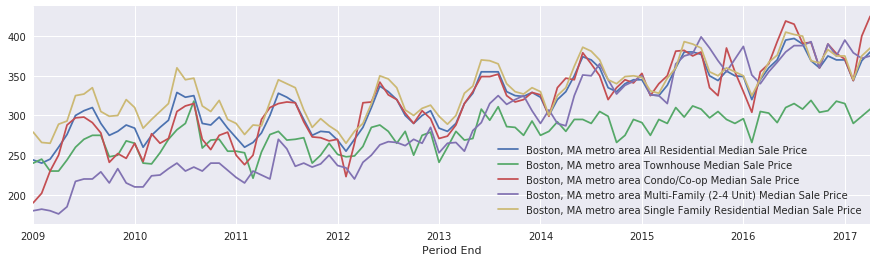

In [61]:
plot(bos_df,'.+Median Sale Price')